In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random
from scipy.optimize import curve_fit
from scipy.stats import chisquare


# Read the experimental data into a Pandas DataFrame.
df = pd.read_fwf('mass.mas03.txt', usecols=(2,3,4,11),
              names=('N', 'Z', 'A', 'avEbind'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=38,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the avEbind column won't be numeric. Coerce to float and drop these entries.
df['avEbind'] = pd.to_numeric(df['avEbind'], errors='coerce')
df = df.dropna()

# Also convert from keV to MeV.
df['avEbind'] /= 1000

# Group the DataFrame by nucleon number, A.
gdf = df.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
maxavEbind = gdf.apply(lambda t: t[t.avEbind==t.avEbind.max()])

matriz = maxavEbind.to_numpy()
N = matriz[:,0]
Z = matriz[:,1]
A = matriz[:,2]
Ebind = matriz[:,3]

In [2]:
def likelihood(y_obs, y_model):
    chi_squared = (1.0/2.0)*sum((y_obs-y_model)**2)
    return np.exp(-chi_squared)

def sgn(A):
    N = A - Z
    signo = []
    for i in range(len(A)):
        if(Z[i]%2==0 and N[i]%2==0):
            signo.append(1)
        elif(Z[i]%2!=0 and N[i]%2!=0):
            signo.append(-1)
        else:
            signo.append(0)
    return np.array(signo)

def energias_por_nucleon(A,a_v,a_s,a_c,a_a,delta):
    return a_v - a_s/(A**(1/3)) - a_c*(Z**2)/(A**(4/3)) - a_a*((A-2*Z)**2)/(A**2) + sgn(A)*delta/(A**(3/2))

a_v_walk = []
a_s_walk = []
a_c_walk = []
a_a_walk = []
delta_walk = []
l_walk = []

a_v_walk.append(random.random())
a_s_walk.append(random.random())
a_c_walk.append(random.random())
a_a_walk.append(random.random())
delta_walk.append(random.random())


E_init = energias_por_nucleon(A,a_v_walk[0],a_s_walk[0],a_c_walk[0],a_a_walk[0],delta_walk[0])
l_walk.append(likelihood(Ebind, E_init))

print(a_v_walk)
print(a_s_walk)
print(a_c_walk)
print(a_a_walk)
print(delta_walk)
print(l_walk)

n_iterations = 20000 #this is the number of iterations I want to make
for i in range(n_iterations):
    a_v_prime = np.random.normal(a_v_walk[i], 1) 
    a_s_prime = np.random.normal(a_s_walk[i], 1)
    a_c_prime = np.random.normal(a_c_walk[i], 1)
    a_a_prime = np.random.normal(a_a_walk[i], 1)
    delta_prime = np.random.normal(delta_walk[i], 1)


    E_init = energias_por_nucleon(A,a_v_walk[i],a_s_walk[i],a_c_walk[i],a_a_walk[i],delta_walk[i])
    E_prime = energias_por_nucleon(A,a_v_prime,a_s_prime,a_c_prime,a_a_prime,delta_prime)
    
    l_prime = likelihood(Ebind, E_prime)
    l_init = likelihood(Ebind, E_init)
    
    alpha = l_prime/l_init

    if(alpha>=1.0):
        a_v_walk.append(a_v_prime)
        a_s_walk.append(a_s_prime)
        a_c_walk.append(a_c_prime)
        a_a_walk.append(a_a_prime)
        delta_walk.append(delta_prime)
        l_walk.append(l_prime)
    else:
        beta = random.random()
        if(beta<=alpha):
            a_v_walk.append(a_v_prime)
            a_s_walk.append(a_s_prime)
            a_c_walk.append(a_c_prime)
            a_a_walk.append(a_a_prime)
            delta_walk.append(delta_prime)
            l_walk.append(l_prime)
        else:
            a_v_walk.append(a_v_walk[i])
            a_s_walk.append(a_s_walk[i])
            a_c_walk.append(a_c_walk[i])
            a_a_walk.append(a_a_walk[i])
            delta_walk.append(delta_walk[i])
            l_walk.append(l_walk[i])

max_likelihood_id = np.argmax(np.array(l_walk))
best_a_v = a_v_walk[max_likelihood_id]
best_a_s = a_s_walk[max_likelihood_id]
best_a_c = a_c_walk[max_likelihood_id]
best_a_a = a_a_walk[max_likelihood_id]
best_delta = delta_walk[max_likelihood_id]

print(l_walk[max_likelihood_id])
print(best_a_v)
print(best_a_s)
print(best_a_c)
print(best_a_a)
print(best_delta)

[0.42404584357691477]
[0.47031212777643083]
[0.6730454682488528]
[0.6996463410975968]
[0.36208836372366116]
[0.0]
0.0005771376918782229
15.633525857771318
16.74953169740568
0.8959868870316036
-1.4362475746304089
5.948996833109787


3.3880274747273207


<Figure size 1080x720 with 0 Axes>

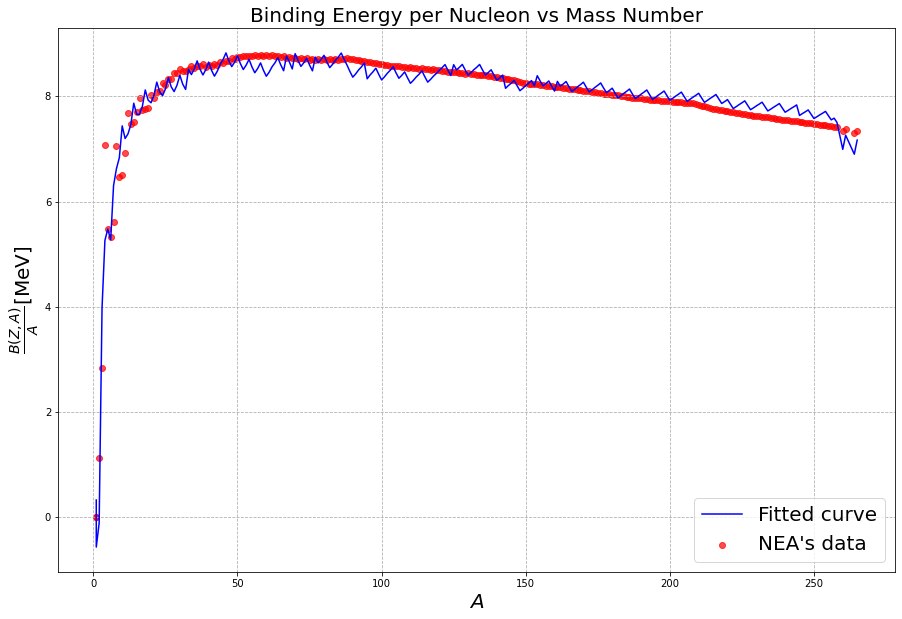

In [3]:
figura = plt.figure(figsize=(15,10))
plt.grid(b=True, linestyle='--')
plt.scatter(a_v_walk,-np.log(l_walk),alpha=0.3, color="red", label=r"$\alpha$")
plt.scatter(a_s_walk,-np.log(l_walk),alpha=0.3, color="blue",label=r"$\beta$")
plt.scatter(a_c_walk,-np.log(l_walk),alpha=0.3, color="green", label=r"$\gamma$")
plt.scatter(a_a_walk,-np.log(l_walk),alpha=0.3, color="magenta", label=r"$\epsilon$")
plt.scatter(delta_walk,-np.log(l_walk),alpha=0.3, color="black", label=r"$\delta$")
plt.ylim(ymin=0, ymax=100)
plt.xlabel("Values of the parameters", fontsize=20)
plt.ylabel(r'$-\ln(L)$', fontsize=20)
plt.title("Likelihood vs Values of the Parameters", fontsize=20)
plt.legend(fontsize=20)
#plt.show()
plt.savefig("Likelihood_1.png")
plt.clf()

figura = plt.figure(figsize=(15,10))
best_E = energias_por_nucleon(A,best_a_v,best_a_s,best_a_c,best_a_a,best_delta)
plt.grid(b=True, linestyle='--')
plt.scatter(A,Ebind, alpha=0.7, color="red", label='NEA\'s data')
plt.plot(A, best_E, color="blue", label="Fitted curve")
plt.xlabel(r'$A$', fontsize=20)
plt.ylabel(r'$\frac{B(Z,A)}{A}[\mathrm{MeV}]$', fontsize=20)
plt.title("Binding Energy per Nucleon vs Mass Number", fontsize=20)
plt.legend(fontsize=20)
plt.savefig("MH1.png")
#plt.show()

chi2 = ((Ebind-best_E)**2)/(Ebind)
chi2 = chi2[2:]
print(np.sum(chi2))

In [4]:
maxavEbind_n = maxavEbind[(maxavEbind.avEbind>= 7.0)]
matriz = maxavEbind_n.to_numpy()
N = matriz[:,0]
Z = matriz[:,1]
A = matriz[:,2]
Ebind = matriz[:,3]

In [5]:
a_v_walk = []
a_s_walk = []
a_c_walk = []
a_a_walk = []
delta_walk = []
l_walk = []

a_v_walk.append(15.2114893512163)
a_s_walk.append(15.677816204167584)
a_c_walk.append(0.842912736840988)
a_a_walk.append(0.2715807404837726)
delta_walk.append(6.309095647537229)


E_init = energias_por_nucleon(A,a_v_walk[0],a_s_walk[0],a_c_walk[0],a_a_walk[0],delta_walk[0])
l_walk.append(likelihood(Ebind, E_init))

print(a_v_walk)
print(a_s_walk)
print(a_c_walk)
print(a_a_walk)
print(delta_walk)
print(l_walk)

n_iterations = 20000 #this is the number of iterations I want to make
for i in range(n_iterations):
    a_v_prime = np.random.normal(a_v_walk[i], 1) 
    a_s_prime = np.random.normal(a_s_walk[i], 1)
    a_c_prime = np.random.normal(a_c_walk[i], 1)
    a_a_prime = np.random.normal(a_a_walk[i], 1)
    delta_prime = np.random.normal(delta_walk[i], 1)


    E_init = energias_por_nucleon(A,a_v_walk[i],a_s_walk[i],a_c_walk[i],a_a_walk[i],delta_walk[i])
    E_prime = energias_por_nucleon(A,a_v_prime,a_s_prime,a_c_prime,a_a_prime,delta_prime)
    
    l_prime = likelihood(Ebind, E_prime)
    l_init = likelihood(Ebind, E_init)
    
    alpha = l_prime/l_init

    if(alpha>=1.0):
        a_v_walk.append(a_v_prime)
        a_s_walk.append(a_s_prime)
        a_c_walk.append(a_c_prime)
        a_a_walk.append(a_a_prime)
        delta_walk.append(delta_prime)
        l_walk.append(l_prime)
    else:
        beta = random.random()
        if(beta<=alpha):
            a_v_walk.append(a_v_prime)
            a_s_walk.append(a_s_prime)
            a_c_walk.append(a_c_prime)
            a_a_walk.append(a_a_prime)
            delta_walk.append(delta_prime)
            l_walk.append(l_prime)
        else:
            a_v_walk.append(a_v_walk[i])
            a_s_walk.append(a_s_walk[i])
            a_c_walk.append(a_c_walk[i])
            a_a_walk.append(a_a_walk[i])
            delta_walk.append(delta_walk[i])
            l_walk.append(l_walk[i])

max_likelihood_id = np.argmax(np.array(l_walk))
best_a_v = a_v_walk[max_likelihood_id]
best_a_s = a_s_walk[max_likelihood_id]
best_a_c = a_c_walk[max_likelihood_id]
best_a_a = a_a_walk[max_likelihood_id]
best_delta = delta_walk[max_likelihood_id]

print(l_walk[max_likelihood_id])
print(best_a_v)
print(best_a_s)
print(best_a_c)
print(best_a_a)
print(best_delta)

[15.2114893512163]
[15.677816204167584]
[0.842912736840988]
[0.2715807404837726]
[6.309095647537229]
[0.019922010924969143]
0.025842571857968132
15.882269947486193
16.45616887559861
0.9714722760162067
-2.254125711368122
8.056734485341103


<Figure size 1080x720 with 0 Axes>

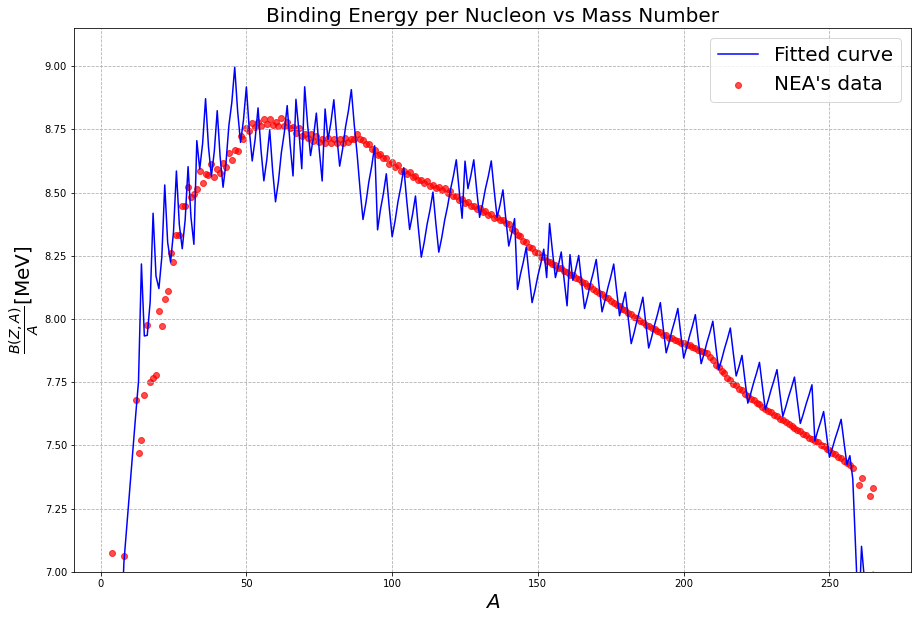

In [7]:
figura = plt.figure(figsize=(15,10))
plt.grid(b=True, linestyle='--')
plt.scatter(a_v_walk,-np.log(l_walk),alpha=0.3, color="red", label=r"$\alpha$")
plt.scatter(a_s_walk,-np.log(l_walk),alpha=0.3, color="blue",label=r"$\beta$")
plt.scatter(a_c_walk,-np.log(l_walk),alpha=0.3, color="green", label=r"$\gamma$")
plt.scatter(a_a_walk,-np.log(l_walk),alpha=0.3, color="magenta", label=r"$\epsilon$")
plt.scatter(delta_walk,-np.log(l_walk),alpha=0.3, color="black", label=r"$\delta$")
plt.xlabel("Values of the parameters", fontsize=20)
plt.ylabel(r'$-\ln(L)$', fontsize=20)
plt.title("Likelihood vs Values of the Parameters", fontsize=20)
plt.legend(fontsize=20)
#plt.show()
plt.savefig("Likelihood_2.png")
plt.clf()

figura = plt.figure(figsize=(15,10))
best_E = energias_por_nucleon(A,best_a_v,best_a_s,best_a_c,best_a_a,best_delta)
plt.grid(b=True, linestyle='--')
plt.scatter(A,Ebind, alpha=0.7, color="red", label='NEA\'s data')
plt.plot(A, best_E, color="blue", label="Fitted curve")
plt.xlabel(r'$A$', fontsize=20)
plt.ylabel(r'$\frac{B(Z,A)}{A}[\mathrm{MeV}]$', fontsize=20)
plt.title("Binding Energy per Nucleon vs Mass Number", fontsize=20)
plt.ylim(ymin=7)
plt.legend(fontsize=20)
plt.savefig("MH2.png")
#plt.show()